In [1]:
import pandas as pd
import json

from llm_political_analysis.modules.summarize import summarize_text
from llm_political_analysis.modules.prompts import get_prompts, policy_areas
from llm_political_analysis.modules.analyze import analyze_text

### Setup the file, issue area and model you want to use

In [2]:
# EDIT THIS WITH YOUR OWN FILE
filepath = '../data/plaintext/0 Calibration - HUN 2010 Soc Dem.txt'

# OPTIONS ARE 'european_union', 'taxation', 'lifestyle', 'immigration', 'environment', 'decentralization'
issue_area = 'taxation'
if issue_area not in policy_areas:
    raise ValueError(f'Invalid issue area: {issue_area}')

# OPTIONS ARE 'gpt-4o', 'gpt-4', 'gpt-3.5-turbo'
model = "gpt-3.5-turbo"
if model not in ['gpt-4o', 'gpt-4', 'gpt-3.5-turbo']:
    raise ValueError(f'Invalid model: {model}')

# Read the long manifesto text from a .txt file
with open(filepath, 'r') as file:
    long_manifesto_text = file.read()

In [3]:
from llm_political_analysis.modules.prompts import policy_scales
policy_scales[issue_area]

'toward Spending versus Taxation. Classify the\nmanifesto on this policy using a ten point scale, where a 1 means strongly\nfavors improving public services, a 5 means the party takes a position in\nthe middle or balanced position between raising spending and reducing\ntaxes, and a 10 means strongly favors reducing taxes. If the text of the\nmanifesto does not provide a clear position on spending vs taxation, return\nthe result of NA (meaning non-applicable).'

### Generates a summary of the chosen file, with a focus on a specific issue area


In [4]:
# Summarize the long manifesto text
manifesto_summary = summarize_text(long_manifesto_text, policy_areas.get(issue_area, 'general policy issues'))
print(manifesto_summary)

1. Increase state support for healthcare, education, culture, research, and science.
2. Create and protect jobs through state investments and guarantees.
3. Ensure social security for workers and retirees.
4. Implement radical taxation on high incomes.
5. Support wage earners through tax and contribution rebates.
6. Establish strong labor protection and nationwide interest reconciliation based on equality.
7. Ensure free choice of doctors and healthcare institutions.
8. Drastically increase the income of healthcare workers.
9. Create a health insurance fund with independent parliamentary oversight.
10. Maintain a unified and national social insurance system in healthcare.
11. Guarantee the value of pensions by the state, not just the constitution.
12. Significantly increase the current low education budget.
13. Ensure equal opportunities and freedom of education.
14. Link vocational training contributions to the wage bill.
15. Provide credible mass communication based on a realistic bu

### Create a list of prompts to try
#### If you'd like to modify the prompt list, you can either edit modules/prompts.py or create a list here

In [5]:
prompts = get_prompts(issue_area, manifesto_summary)
print(f'Got {len(prompts)} prompts to try, for example: \n {prompts[0]}')


Got 9 prompts to try, for example: 
 [{'role': 'system', 'content': 'You are an expert social scientist with a PhD in political science. This will be fun! You are conducting research on the policy positions that European parties in parliamentary democracies take in their political manifestos. Political manifestos are documents parties produce to explain their policy positions to voters in an election. For the following text of a party manifesto, please classify the party position on the overall orientation of the party toward Spending versus Taxation. Classify the manifesto on this policy using a ten point scale, where a 1 means strongly favors improving public services, a 5 means the party takes a position in the middle or balanced position between raising spending and reducing taxes, and a 10 means strongly favors reducing taxes. If the text of the manifesto does not provide a clear position on spending vs taxation, return the result of NA (meaning non-applicable).Only give the score

### Iterate over the prompts and analyze the manifesto with each, collecting the results. 

In [7]:
# Analyze the manifesto summary with different prompts
results = []
for prompt in prompts:
    print(f'Analyzed so far: {len(results)} out of {len(prompts)} prompts', end='\r')
    response = analyze_text(prompt, model=model)
    response_dict = json.loads(response)
    response_dict['prompt'] = prompt
    results.append(response_dict)

In [7]:
# Display the results in a DataFrame
df_results = pd.DataFrame(results)
df_results['filepath'] = filepath
df_results['issue_area'] = issue_area
df_results

,score,explanation,prompt,filepath,issue_area
0,6,"The party is in favor of the European Union, a...","[{'role': 'system', 'content': 'You are an exp...",../data/plaintext/0 Calibration - HUN 2010 Soc...,taxation
1,1,The party strongly favors improving public ser...,"[{'role': 'system', 'content': 'You are an exp...",../data/plaintext/0 Calibration - HUN 2010 Soc...,taxation
2,5,The party takes a middle position on social an...,"[{'role': 'system', 'content': 'You are an exp...",../data/plaintext/0 Calibration - HUN 2010 Soc...,taxation
3,5,The party does not provide a clear position on...,"[{'role': 'system', 'content': 'You are an exp...",../data/plaintext/0 Calibration - HUN 2010 Soc...,taxation
4,1,The party strongly supports environmental prot...,"[{'role': 'system', 'content': 'You are an exp...",../data/plaintext/0 Calibration - HUN 2010 Soc...,taxation
5,1,The party strongly favors political decentrali...,"[{'role': 'system', 'content': 'You are an exp...",../data/plaintext/0 Calibration - HUN 2010 Soc...,taxation
6,6,"The party is in favor of the European Union, a...","[{'role': 'system', 'content': 'You are an exp...",../data/plaintext/0 Calibration - HUN 2010 Soc...,taxation
7,1,The party strongly favors improving public ser...,"[{'role': 'system', 'content': 'You are an exp...",../data/plaintext/0 Calibration - HUN 2010 Soc...,taxation
8,5,The party takes a middle position on this policy.,"[{'role': 'system', 'content': 'You are an exp...",../data/plaintext/0 Calibration - HUN 2010 Soc...,taxation
9,1,The manifesto does not provide a clear positio...,"[{'role': 'system', 'content': 'You are an exp...",../data/plaintext/0 Calibration - HUN 2010 Soc...,taxation


<Axes: >

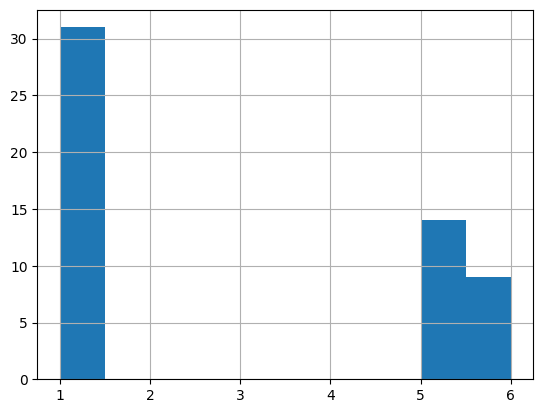

In [8]:
df_results.score.hist()

In [11]:
df_results.to_excel('manifesto_analysis_results.xlsx', index=False)